# Experiment 1.1

This notebook is to explore the problem and challenges experienced by the network when predicting different slices of the data (i.e., shifted data).

In [156]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
import numpy as np
import pandas as pd

import altair as alt

from IPython.display import display, Markdown, Latex

In [158]:
REPO_HOME="/raid/home/jupyter-pander14/"

In [159]:
import sys
sys.path.insert(0,f'{REPO_HOME}/underspecification')
sys.path.insert(0,f'{REPO_HOME}/deeptype2')


In [160]:
import pydeeptype2

In [161]:
import pyunderspecification.compare_graphs as cg

## Prepare the data for analysis

In [162]:
df_perf = pd.read_csv('/large/metabric/underspecification/results/experiment2.csv',sep="|")
df_perf['cluster'] = ''
df_perf['shifted'] = ''
df_perf[['cluster','shifted']] = list(df_perf['key'].str.split(","))
df_perf

,key,rep,seed,subtype,precision,recall,f1-score,support,cluster,shifted
0,"0,True",0,1,Basal,0.67,0.72,0.69,25,0,True
1,"0,True",0,1,Her2,0.73,0.38,0.50,29,0,True
2,"0,True",0,1,LumA,0.82,0.87,0.85,95,0,True
3,"0,True",0,1,LumB,0.74,0.84,0.79,55,0,True
4,"0,True",0,1,Normal,0.62,0.72,0.67,18,0,True
...,...,...,...,...,...,...,...,...,...,...
8635,"2,False",5,30,LumB,0.72,0.80,0.76,232,2,False
8636,"2,False",5,30,Normal,0.52,0.55,0.54,76,2,False
8637,"2,False",5,30,claudin-low,0.86,0.86,0.86,93,2,False
8638,"2,False",5,30,macro_avg,0.70,0.66,0.63,961,2,False


In [163]:
df_perf.head()

,key,rep,seed,subtype,precision,recall,f1-score,support,cluster,shifted
0,"0,True",0,1,Basal,0.67,0.72,0.69,25,0,True
1,"0,True",0,1,Her2,0.73,0.38,0.50,29,0,True
2,"0,True",0,1,LumA,0.82,0.87,0.85,95,0,True
3,"0,True",0,1,LumB,0.74,0.84,0.79,55,0,True
4,"0,True",0,1,Normal,0.62,0.72,0.67,18,0,True


In [164]:
def process(df):
    df = df.set_index('shifted')
    unshifted = df.loc['False','f1-score']
    shifted = df.loc['True','f1-score']
    return unshifted-shifted

In [165]:
df_paired_perf = df_perf.groupby(['rep','seed','subtype','cluster'])[['shifted','f1-score']].apply(process)
df_paired_perf.name = "f1-score (unshifted-shifted)"
df_paired_perf = df_paired_perf.reset_index()
df_paired_perf

,rep,seed,subtype,cluster,f1-score (unshifted-shifted)
0,0,1,Basal,0,0.03
1,0,1,Basal,1,-0.02
2,0,1,Basal,2,0.73
3,0,1,Her2,0,0.18
4,0,1,Her2,1,0.17
...,...,...,...,...,...
4315,5,30,macro_avg,1,0.04
4316,5,30,macro_avg,2,0.01
4317,5,30,weighted_avg,0,0.07
4318,5,30,weighted_avg,1,0.03


In [166]:
shifted_f1 = df_perf.set_index('shifted').loc['True',['rep','seed','subtype','cluster','f1-score']]
shifted_f1.columns = list(shifted_f1.columns[:-1]) + ['f1-score (shifted)']
df_paired_perf = df_paired_perf.set_index(['rep','seed','subtype','cluster']).join(shifted_f1.set_index(['rep','seed','subtype','cluster'])).reset_index()


In [167]:
unshifted_f1 = df_perf.set_index('shifted').loc['False',['rep','seed','subtype','cluster','f1-score']]
unshifted_f1.columns = list(unshifted_f1.columns[:-1]) + ['f1-score (unshifted)']
df_paired_perf = df_paired_perf.set_index(['rep','seed','subtype','cluster']).join(unshifted_f1.set_index(['rep','seed','subtype','cluster'])).reset_index()


In [168]:
df_paired_perf

,rep,seed,subtype,cluster,f1-score (unshifted-shifted),f1-score (shifted),f1-score (unshifted)
0,0,1,Basal,0,0.03,0.69,0.72
1,0,1,Basal,1,-0.02,0.84,0.82
2,0,1,Basal,2,0.73,0.00,0.73
3,0,1,Her2,0,0.18,0.50,0.68
4,0,1,Her2,1,0.17,0.44,0.61
...,...,...,...,...,...,...,...
4315,5,30,macro_avg,1,0.04,0.65,0.69
4316,5,30,macro_avg,2,0.01,0.62,0.63
4317,5,30,weighted_avg,0,0.07,0.73,0.80
4318,5,30,weighted_avg,1,0.03,0.71,0.74


## Problem Definition and Evaluation

In [169]:
import scipy.stats as ss

In [170]:
source = df_paired_perf.set_index('subtype').loc['Her2']
source = source.set_index(['rep','cluster'])
for index in source.index.unique():
    f = source.loc[index,'f1-score (shifted)']
    r = source.loc[index,'f1-score (unshifted)']
    source.loc[index,'rank'] = ss.rankdata(-(f+r)/2)
    source.loc[index,'avg f1-score'] = ((f+r)/2).values #2*(f*r)/(f+r)
source = source.reset_index()
top_k = 5
mask = source['rank'] > top_k
source.loc[:,'rank'] = source.loc[:,'rank'].astype(int).astype(str)
source.loc[mask,'rank'] = f'>{top_k}'
chart = alt.Chart(source).transform_calculate(
    Seed="datum.seed"# + '-' + datum.seed"
).mark_point(filled=True).encode(
    x=alt.X('f1-score (unshifted):Q',scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('f1-score (shifted):Q'),
    size='avg f1-score:Q',
    column='cluster',
    row='rep',
    color='rank:N',
    tooltip=['Seed:Q','rank','avg f1-score','f1-score (unshifted)','f1-score (shifted)']
)
chart.resolve_scale(x='independent')

/tmp/ipykernel_973356/1595641894.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  f = source.loc[index,'f1-score (shifted)']
/tmp/ipykernel_973356/1595641894.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = source.loc[index,'f1-score (unshifted)']
/tmp/ipykernel_973356/1595641894.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  source.loc[index,'rank'] = ss.rankdata(-(f+r)/2)
/tmp/ipykernel_973356/1595641894.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  source.loc[index,'avg f1-score'] = ((f+r)/2).values #2*(f*r)/(f+r)
/tmp/ipykernel_973356/1595641894.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  f = source.loc[index,'f1-score (shifted)']
/tmp/ipykernel_973356/1595641894.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = source.loc[index,'f1-score (unshifted)']
/tmp/ipykernel_973356/15956418

alt.Chart(...)

## Evaluate Graph metabric/graphs/A_1.csv

In [171]:
#!head /large/metabric/underspecification/results/experiment2_ae.call_encoded.csv

In [172]:
data_file=f"/large/metabric/expression_with_gene_ids_min_max_no_pam50.csv.gz"
targets_file=f"{REPO_HOME}/underspecification/metabric/pam50_claudinlow_subtype.csv"
sample_sample_graph=f'{REPO_HOME}/underspecification/metabric/graphs/A_1.csv'
encoding_file=f'/large/metabric/underspecification/results/experiment2_ae.call_encoded.csv'
data_test_labels_file='/large/metabric/underspecification/results/experiment2_data.test.labels.csv'
num_to_target_file=f'{REPO_HOME}/underspecification/metabric/num_to_target.csv'
index_dir=f"{REPO_HOME}/underspecification/metabric/data/indices"
dt = cg.Data(data_file,targets_file,sample_sample_graph,encoding_file,data_test_labels_file,num_to_target_file,index_dir)

## Metabric graph

In [173]:
expression_with_gene_ids = pd.read_csv("/large/metabric/expression_with_gene_ids.csv.gz",index_col=0)

In [174]:
hX,hy,hA = dt.helper_ret

In [175]:
knowledge_genes = ["TBP","B2M","PPIA"]
X = expression_with_gene_ids[knowledge_genes]

In [176]:
yher2 = hy[hy=='Her2']

In [177]:
Xher2 = X.loc[yher2.index]
Xher2

,TBP,B2M,PPIA
Sample ID,,,
MB-0035,7.389018,22.197751,25.453750
MB-0079,6.952544,25.596348,32.407484
MB-0113,7.487772,24.472134,25.818344
MB-0129,7.433414,25.168222,27.131902
MB-0148,7.619431,25.249636,26.960935
...,...,...,...
MB-7262,7.805507,25.297318,27.339912
MB-7273,7.291807,24.775228,23.498472
MB-7275,7.004781,24.864300,26.013882


In [178]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xher3 = scaler.fit_transform(Xher2)

In [179]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 10
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(Xher3)
A = nbrs.kneighbors_graph(Xher3,mode='distance')
A = pd.DataFrame(A.toarray(),index=Xher2.index,columns=Xher2.index)
A

Sample ID,MB-0035,MB-0079,MB-0113,MB-0129,MB-0148,MB-0152,MB-0188,MB-0221,MB-0230,MB-0249,...,MB-7250,MB-7251,MB-7252,MB-7256,MB-7260,MB-7262,MB-7273,MB-7275,MB-7279,MB-7281
Sample ID,,,,,,,,,,,,,,,,,,,,,
MB-0035,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.118204,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000
MB-0079,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000
MB-0113,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.055961,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000
MB-0129,0.0,0.0,0.0,0.000000,0.000000,0.064589,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000
MB-0148,0.0,0.0,0.0,0.088322,0.000000,0.082296,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.091819,0.00000,0.0,0.0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7262,0.0,0.0,0.0,0.000000,0.091819,0.145126,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000
MB-7273,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.07968
MB-7275,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.067011,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.00000


In [180]:
sel_data = df_paired_perf.set_index('subtype').loc['Her2'].reset_index()
sel_data.head()

,subtype,rep,seed,cluster,f1-score (unshifted-shifted),f1-score (shifted),f1-score (unshifted)
0,Her2,0,1,0,0.18,0.50,0.68
1,Her2,0,1,1,0.17,0.44,0.61
2,Her2,0,1,2,0.12,0.00,0.12
3,Her2,0,2,0,0.39,0.26,0.65
4,Her2,0,2,1,0.30,0.00,0.30


In [181]:
f = sel_data['f1-score (shifted)']
r = sel_data['f1-score (unshifted)']
sel_data['avg f1-score'] = ((f+r)/2).values # 2/(1/f+1/r)

In [192]:
def sel_top(group_df,by,ascending=False):
    return group_df.sort_values(by=by,ascending=ascending).iloc[0]

sel_data_by_unshifted = sel_data.groupby(['cluster','rep']).apply(lambda group_df: sel_top(group_df,'f1-score (unshifted)'))
sel_data_by_unshifted

subtype  rep  seed cluster  f1-score (unshifted-shifted)  \
cluster rep                                                            
0       0      Her2    0    30       0                          0.36   
        1      Her2    1    29       0                          0.60   
        2      Her2    2     7       0                          0.45   
        3      Her2    3    30       0                          0.53   
        4      Her2    4     4       0                          0.47   
        5      Her2    5    12       0                          0.43   
1       0      Her2    0     4       1                          0.12   
        1      Her2    1     3       1                          0.16   
        2      Her2    2     1       1                          0.26   
        3      Her2    3     6       1                          0.20   
        4      Her2    4    30       1                          0.20   
        5      Her2    5    12       1                          0.22   
2       0      Her2    0    11       2                          0.18   
        1      Her2    1    28       2                          0.37   
        2      Her2    2    20       2                          0.34   
        3      Her2    3    13       2                          0.02   
        4      Her2    4    15       2                         -0.01   
        5      Her2    5    18       2                          0.09   

             f1-score (shifted)  f1-score (unshifted)  avg f1-score  
cluster rep                                                          
0       0                  0.35                  0.71         0.530  
        1                  0.23                  0.83         0.530  
        2                  0.45                  0.90         0.675  
        3                  0.22                  0.75         0.485  
        4                  0.34                  0.81         0.575  
        5                  0.35                  0.78         0.565  
1       0                  0.54                  0.66         0.600  
        1                  0.58                  0.74         0.660  
        2                  0.47                  0.73         0.600  
        3                  0.48                  0.68         0.580  
        4                  0.55                  0.75         0.650  
        5                  0.50                  0.72         0.610  
2       0                  0.00                  0.18         0.090  
        1                  0.00                  0.37         0.185  
        2                  0.00                  0.34         0.170  
        3                  0.36                  0.38         0.370  
        4                  0.35                  0.34         0.345  
        5                  0.27                  0.36         0.315

In [193]:
sel_data_by_unshifted['avg f1-score - f1-score (unshifted)'] = sel_data_by_unshifted['avg f1-score']-sel_data_by_unshifted['f1-score (unshifted)']
sel_data_by_unshifted.sort_values(by='avg f1-score - f1-score (unshifted)')

subtype  rep  seed cluster  f1-score (unshifted-shifted)  \
cluster rep                                                            
0       1      Her2    1    29       0                          0.60   
        3      Her2    3    30       0                          0.53   
        4      Her2    4     4       0                          0.47   
        2      Her2    2     7       0                          0.45   
        5      Her2    5    12       0                          0.43   
2       1      Her2    1    28       2                          0.37   
0       0      Her2    0    30       0                          0.36   
2       2      Her2    2    20       2                          0.34   
1       2      Her2    2     1       1                          0.26   
        5      Her2    5    12       1                          0.22   
        3      Her2    3     6       1                          0.20   
        4      Her2    4    30       1                          0.20   
2       0      Her2    0    11       2                          0.18   
1       1      Her2    1     3       1                          0.16   
        0      Her2    0     4       1                          0.12   
2       5      Her2    5    18       2                          0.09   
        3      Her2    3    13       2                          0.02   
        4      Her2    4    15       2                         -0.01   

             f1-score (shifted)  f1-score (unshifted)  avg f1-score  \
cluster rep                                                           
0       1                  0.23                  0.83         0.530   
        3                  0.22                  0.75         0.485   
        4                  0.34                  0.81         0.575   
        2                  0.45                  0.90         0.675   
        5                  0.35                  0.78         0.565   
2       1                  0.00                  0.37         0.185   
0       0                  0.35                  0.71         0.530   
2       2                  0.00                  0.34         0.170   
1       2                  0.47                  0.73         0.600   
        5                  0.50                  0.72         0.610   
        3                  0.48                  0.68         0.580   
        4                  0.55                  0.75         0.650   
2       0                  0.00                  0.18         0.090   
1       1                  0.58                  0.74         0.660   
        0                  0.54                  0.66         0.600   
2       5                  0.27                  0.36         0.315   
        3                  0.36                  0.38         0.370   
        4                  0.35                  0.34         0.345   

             avg f1-score - f1-score (unshifted)  
cluster rep                                       
0       1                                 -0.300  
        3                                 -0.265  
        4                                 -0.235  
        2                                 -0.225  
        5                                 -0.215  
2       1                                 -0.185  
0       0                                 -0.180  
2       2                                 -0.170  
1       2                                 -0.130  
        5                                 -0.110  
        3                                 -0.100  
        4                                 -0.100  
2       0                                 -0.090  
1       1                                 -0.080  
        0                                 -0.060  
2       5                                 -0.045  
        3                                 -0.010  
        4                                  0.005

# Conclusion
Cluster 0 has the biggest problem with underspecification as measured by the f1-score lost by not having
access to the unshifted dataset. A choice would have been made based only on unshifted results and that choice would have been worse than on other datasets/reps/clusters/etc.

In [194]:
# grab top 5 or in a more general sense these could be all or any subset of the runs
selected = sel_data_by_unshifted.sort_values(by='avg f1-score - f1-score (unshifted)').iloc[:5]
selected

subtype  rep  seed cluster  f1-score (unshifted-shifted)  \
cluster rep                                                            
0       1      Her2    1    29       0                          0.60   
        3      Her2    3    30       0                          0.53   
        4      Her2    4     4       0                          0.47   
        2      Her2    2     7       0                          0.45   
        5      Her2    5    12       0                          0.43   

             f1-score (shifted)  f1-score (unshifted)  avg f1-score  \
cluster rep                                                           
0       1                  0.23                  0.83         0.530   
        3                  0.22                  0.75         0.485   
        4                  0.34                  0.81         0.575   
        2                  0.45                  0.90         0.675   
        5                  0.35                  0.78         0.565   

             avg f1-score - f1-score (unshifted)  
cluster rep                                       
0       1                                 -0.300  
        3                                 -0.265  
        4                                 -0.235  
        2                                 -0.225  
        5                                 -0.215

In [195]:
source = df_paired_perf.set_index('subtype').loc['Her2']
source = source.set_index(['cluster','rep']).loc[selected.index]
for index in source.index.unique():
    f = source.loc[index,'f1-score (shifted)']
    r = source.loc[index,'f1-score (unshifted)']
    source.loc[index,'rank'] = ss.rankdata(-(f+r)/2)
    source.loc[index,'avg f1-score'] = ((f+r)/2).values #2*(f*r)/(f+r)
source = source.reset_index()
top_k = 5
mask = source['rank'] > top_k
source.loc[:,'rank'] = source.loc[:,'rank'].astype(int).astype(str)
source.loc[mask,'rank'] = f'>{top_k}'
chart = alt.Chart(source).transform_calculate(
    Seed="datum.seed"# + '-' + datum.seed"
).mark_point(filled=True).encode(
    x=alt.X('f1-score (unshifted):Q',scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('f1-score (shifted):Q'),
    size='avg f1-score:Q',
    column='cluster',
    row='rep',
    color='rank:N',
    tooltip=['Seed:Q','rank','avg f1-score','f1-score (unshifted)','f1-score (shifted)']
)
chart.resolve_scale(x='independent')

/tmp/ipykernel_973356/2668909796.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  f = source.loc[index,'f1-score (shifted)']
/tmp/ipykernel_973356/2668909796.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = source.loc[index,'f1-score (unshifted)']
/tmp/ipykernel_973356/2668909796.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  source.loc[index,'rank'] = ss.rankdata(-(f+r)/2)
/tmp/ipykernel_973356/2668909796.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  source.loc[index,'avg f1-score'] = ((f+r)/2).values #2*(f*r)/(f+r)
/tmp/ipykernel_973356/2668909796.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  f = source.loc[index,'f1-score (shifted)']
/tmp/ipykernel_973356/2668909796.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  r = source.loc[index,'f1-score (unshifted)']
/tmp/ipykernel_973356/26689097

alt.Chart(...)

Now grab the data related to these

In [197]:
sel_data2 = sel_data.set_index(['cluster','rep']).loc[selected.index].reset_index()
sel_data2

,cluster,rep,subtype,seed,f1-score (unshifted-shifted),f1-score (shifted),f1-score (unshifted),avg f1-score
0,0,1,Her2,1,0.43,0.36,0.79,0.575
1,0,1,Her2,2,0.50,0.27,0.77,0.520
2,0,1,Her2,3,0.54,0.17,0.71,0.440
3,0,1,Her2,4,0.73,0.00,0.73,0.365
4,0,1,Her2,5,0.52,0.27,0.79,0.530
...,...,...,...,...,...,...,...,...
145,0,5,Her2,26,-0.03,0.36,0.33,0.345
146,0,5,Her2,27,0.45,0.12,0.57,0.345
147,0,5,Her2,28,0.42,0.23,0.65,0.440
148,0,5,Her2,29,0.40,0.17,0.57,0.370


The question is wheter we can improve this ranking?

In [198]:
import scipy.stats as stats

def get_ranks(selected,sel_data2,by,n = 5,ascending=False):
    ranks = {}
    for ix in selected.index:
        ranks[ix] = sel_data2.set_index(['cluster','rep']).loc[ix].sort_values(by=by,ascending=ascending).iloc[:n]
    return ranks
unshifted_ranks = get_ranks(selected,sel_data2,'f1-score (unshifted)')

def calc_scores(ranks,selected,by,true_col='avg f1-score',verbose=False):
    scores = {}
    for ix in selected.index:
        scores[ix]={}
        x1 = ranks[ix][true_col]
        x2 = ranks[ix][by]
        tau, p_value = stats.kendalltau(x1, x2)
        r, p_value = stats.pearsonr(x1, x2)
        if verbose:
            x1 = ranks[ix][['seed',true_col]]
            x2 = ranks[ix][['seed',by]]
            print(ix)
            print(x1.sort_values(by=true_col))
            print(x2.sort_values(by=by))
            print(tau)
        scores[ix]['tau'] = tau
        scores[ix]['r'] = r
    return scores

/tmp/ipykernel_973356/1686575999.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ranks[ix] = sel_data2.set_index(['cluster','rep']).loc[ix].sort_values(by=by,ascending=ascending).iloc[:n]
/tmp/ipykernel_973356/1686575999.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ranks[ix] = sel_data2.set_index(['cluster','rep']).loc[ix].sort_values(by=by,ascending=ascending).iloc[:n]
/tmp/ipykernel_973356/1686575999.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ranks[ix] = sel_data2.set_index(['cluster','rep']).loc[ix].sort_values(by=by,ascending=ascending).iloc[:n]
/tmp/ipykernel_973356/1686575999.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ranks[ix] = sel_data2.set_index(['cluster','rep']).loc[ix].sort_values(by=by,ascending=ascending).iloc[:n]
/tmp/ipykernel_973356/1686575999.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ranks[i

In [199]:
unshifted_corr_results = pd.DataFrame(calc_scores(unshifted_ranks,selected,'f1-score (unshifted)') ).T
unshifted_corr_results['tau'].mean()

0.19685580164225228

In [200]:
unshifted_corr_results

tau         r
0 1  0.000000  0.076832
  3  0.223607 -0.008802
  4  0.000000  0.046491
  2  0.316228  0.656489
  5  0.444444  0.480977

In [201]:
#graph = pd.read_csv(f'{REPO_HOME}/underspecification/metabric/graphs/A_1.csv',index_col=0)
results = cg.compute_score(sel_data2,A,dt)

In [202]:
alpha = 0.5
results['combined score and f1-score (unshifted)'] = alpha*results['f1-score (unshifted)']+(1-alpha)*results['score']
results.head()

subtype  f1-score (unshifted-shifted)  f1-score (shifted)  \
cluster rep seed                                                             
0       1   1       Her2                          0.43                0.36   
            2       Her2                          0.50                0.27   
            3       Her2                          0.54                0.17   
            4       Her2                          0.73                0.00   
            5       Her2                          0.52                0.27   

                  f1-score (unshifted)  avg f1-score     score  \
cluster rep seed                                                 
0       1   1                     0.79         0.575  0.361495   
            2                     0.77         0.520  0.342126   
            3                     0.71         0.440  0.362626   
            4                     0.73         0.365  0.169704   
            5                     0.79         0.530  0.357211   

                  combined score and f1-score (unshifted)  
cluster rep seed                                           
0       1   1                                    0.575748  
            2                                    0.556063  
            3                                    0.536313  
            4                                    0.449852  
            5                                    0.573606

In [203]:
results = results.reset_index().set_index(['cluster','rep'])

In [204]:
import copy
by = 'combined score and f1-score (unshifted)'
copy_unshifted_ranks = copy.deepcopy(unshifted_ranks)
for cluster,rep in unshifted_ranks.keys():
    print(cluster,rep)
    dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])    
    copy_unshifted_ranks[(cluster,rep)] = copy_unshifted_ranks[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])
    copy_unshifted_ranks[(cluster,rep)][by] = dt1[by]
    copy_unshifted_ranks[(cluster,rep)]=copy_unshifted_ranks[(cluster,rep)].reset_index().set_index(['cluster','rep'])

0 1
0 3
0 4
0 2
0 5


/tmp/ipykernel_973356/65401847.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])
/tmp/ipykernel_973356/65401847.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])
/tmp/ipykernel_973356/65401847.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])
/tmp/ipykernel_973356/65401847.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])
/tmp/ipykernel_973356/65401847.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  dt1 = results.loc[(cluster,rep)].reset_index().set_index(['cluster','rep','seed'])


In [205]:
combined_corr_results = pd.DataFrame(calc_scores(copy_unshifted_ranks,selected,by) ).T
combined_corr_results['tau'].mean()

0.4675729574745244

In [206]:
combined_corr_results

tau         r
0 1  0.600000  0.683779
  3  0.200000  0.280189
  4  0.400000  0.648456
  2  0.400000  0.440854
  5  0.737865  0.475426

In [207]:
unshifted_corr_results

tau         r
0 1  0.000000  0.076832
  3  0.223607 -0.008802
  4  0.000000  0.046491
  2  0.316228  0.656489
  5  0.444444  0.480977

In [ ]:
all_corr_results = pd.DataFrame()
all_corr_results['cluster'] = unshifted_corr_results
all_corr_results['rep'] = 
all_corr_results['r (unshifted)'] = unshifted_corr_results['r']
all_corr_results['r (combined)'] = combined_corr_results['r']

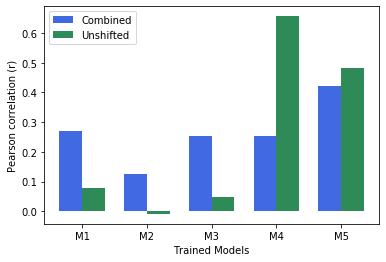

<Figure size 1080x360 with 0 Axes>

In [152]:
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, combined_corr_results['r'], width, color='royalblue')
rects2 = ax.bar(ind+width, unshifted_corr_results['r'], width, color='seagreen')

# for index, row in combined_corr_results.iterrows():
#     value = row['r']
#     plt.text(i, value, value)

# add some

fig = plt.figure(figsize = (15, 5))

ax.set_ylabel('Pearson correlation (r)')
ax.set_xlabel('Trained Models')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( ('M1', 'M2', 'M3', 'M4', 'M5') )

ax.legend( (rects1[0], rects2[0]), ('Combined', 'Unshifted') )

plt.show()

In [42]:
unshifted_corr_results['tau'].mean(),combined_corr_results['tau'].mean()

(0.19685580164225228, 0.22540925533894596)

In [43]:
unshifted_corr_results['r'].mean(),combined_corr_results['r'].mean()

(0.2503974534752212, 0.26504708107591124)

# NOTHING BELOW THIS LINE

In [44]:
top_by_score = results.reset_index().set_index('seed').groupby(['cluster','rep'])['score'].idxmax()
top_by_score

cluster  rep
0        1       4
         2      10
         3      14
         4      12
         5      20
Name: score, dtype: int64

In [45]:
ixs = [tuple(e) for e in list(top_by_score.reset_index().values)]

In [46]:
sel_data

,subtype,rep,seed,cluster,f1-score (unshifted-shifted),f1-score (shifted),f1-score (unshifted),avg f1-score
0,Her2,0,1,0,0.18,0.50,0.68,0.590
1,Her2,0,1,1,0.17,0.44,0.61,0.525
2,Her2,0,1,2,0.12,0.00,0.12,0.060
3,Her2,0,2,0,0.39,0.26,0.65,0.455
4,Her2,0,2,1,0.30,0.00,0.30,0.150
...,...,...,...,...,...,...,...,...
535,Her2,5,29,1,0.00,0.00,0.00,0.000
536,Her2,5,29,2,-0.16,0.33,0.17,0.250
537,Her2,5,30,0,0.40,0.29,0.69,0.490
538,Her2,5,30,1,0.21,0.47,0.68,0.575


## TODO: pick from top n instead of all of them. some of them are bad from a NN standpoint

In [47]:
sel_data.set_index(['cluster','rep','seed']).loc[ixs]

subtype  f1-score (unshifted-shifted)  f1-score (shifted)  \
cluster rep seed                                                             
0       1   4       Her2                          0.73                0.00   
        2   10      Her2                          0.35                0.08   
        3   14      Her2                          0.40                0.27   
        4   12      Her2                          0.41                0.29   
        5   20      Her2                          0.36                0.33   

                  f1-score (unshifted)  avg f1-score  
cluster rep seed                                      
0       1   4                     0.73         0.365  
        2   10                    0.43         0.255  
        3   14                    0.67         0.470  
        4   12                    0.70         0.495  
        5   20                    0.69         0.510

In [48]:
selected

subtype  rep  seed cluster  f1-score (unshifted-shifted)  \
cluster rep                                                            
0       1      Her2    1    29       0                          0.60   
        3      Her2    3    30       0                          0.53   
        4      Her2    4     4       0                          0.47   
        2      Her2    2     7       0                          0.45   
        5      Her2    5    12       0                          0.43   

             f1-score (shifted)  f1-score (unshifted)  avg f1-score  \
cluster rep                                                           
0       1                  0.23                  0.83         0.530   
        3                  0.22                  0.75         0.485   
        4                  0.34                  0.81         0.575   
        2                  0.45                  0.90         0.675   
        5                  0.35                  0.78         0.565   

             avg f1-score - f1-score (unshifted)  
cluster rep                                       
0       1                                 -0.300  
        3                                 -0.265  
        4                                 -0.235  
        2                                 -0.225  
        5                                 -0.215

In [49]:
fixed_index = results.reset_index().drop('subtype',axis=1).set_index(['cluster','rep','seed'])
fixed_index

f1-score (unshifted-shifted)  f1-score (shifted)  \
cluster rep seed                                                     
0       1   1                             0.43                0.36   
            2                             0.50                0.27   
            3                             0.54                0.17   
            4                             0.73                0.00   
            5                             0.52                0.27   
...                                        ...                 ...   
        5   26                           -0.03                0.36   
            27                            0.45                0.12   
            28                            0.42                0.23   
            29                            0.40                0.17   
            30                            0.40                0.29   

                  f1-score (unshifted)  avg f1-score     score  \
cluster rep seed                                                 
0       1   1                     0.79         0.575  0.136631   
            2                     0.77         0.520  0.141658   
            3                     0.71         0.440  0.139544   
            4                     0.73         0.365  0.192172   
            5                     0.79         0.530  0.160031   
...                                ...           ...       ...   
        5   26                    0.33         0.345  0.126163   
            27                    0.57         0.345  0.093505   
            28                    0.65         0.440  0.136210   
            29                    0.57         0.370  0.129929   
            30                    0.69         0.490  0.125833   

                  combined score and f1-score (unshifted)  
cluster rep seed                                           
0       1   1                                    0.463315  
            2                                    0.455829  
            3                                    0.424772  
            4                                    0.461086  
            5                                    0.475015  
...                                                   ...  
        5   26                                   0.228082  
            27                                   0.331752  
            28                                   0.393105  
            29                                   0.349965  
            30                                   0.407916  

[150 rows x 6 columns]

In [50]:
choice_f1_unshifted = cg.choose(results,1)

In [51]:
index = [tuple(v) for v in choice_f1_unshifted.values]
fixed_index.loc[index]

f1-score (unshifted-shifted)  f1-score (shifted)  \
cluster rep seed                                                     
0       1   29                            0.60                0.23   
        2   7                             0.45                0.45   
        3   30                            0.53                0.22   
        4   4                             0.47                0.34   
        5   12                            0.43                0.35   

                  f1-score (unshifted)  avg f1-score     score  \
cluster rep seed                                                 
0       1   29                    0.83         0.530  0.150449   
        2   7                     0.90         0.675  0.126342   
        3   30                    0.75         0.485  0.130211   
        4   4                     0.81         0.575  0.164498   
        5   12                    0.78         0.565  0.140152   

                  combined score and f1-score (unshifted)  
cluster rep seed                                           
0       1   29                                   0.490224  
        2   7                                    0.513171  
        3   30                                   0.440106  
        4   4                                    0.487249  
        5   12                                   0.460076

In [52]:
choice_score = cg.choose(results,5,ranking_column='score')

In [53]:
index = [tuple(v) for v in choice_score.values]
fixed_index.loc[index]

f1-score (unshifted-shifted)  f1-score (shifted)  \
cluster rep seed                                                     
0       1   13                            0.46                0.37   
        2   11                            0.53                0.34   
        3   30                            0.53                0.22   
        4   24                            0.50                0.27   
        5   1                             0.38                0.35   

                  f1-score (unshifted)  avg f1-score     score  \
cluster rep seed                                                 
0       1   13                    0.83         0.600  0.125588   
        2   11                    0.87         0.605  0.108865   
        3   30                    0.75         0.485  0.130211   
        4   24                    0.77         0.520  0.136688   
        5   1                     0.73         0.540  0.114314   

                  combined score and f1-score (unshifted)  
cluster rep seed                                           
0       1   13                                   0.477794  
        2   11                                   0.489432  
        3   30                                   0.440106  
        4   24                                   0.453344  
        5   1                                    0.422157

In [54]:
print('Using unshifted f1-score only:',cg.evaluate_mean(results,choice_f1_unshifted))

Using unshifted f1-score only: 0.31799999999999995


In [55]:
print('Using unshifted f1-score and graph:',cg.evaluate_mean(results,choice_score))

Using unshifted f1-score and graph: 0.30999999999999994


In [ ]:
import matplotlib.pyplot as plt

sel_data_by_unshifted = sel_data_by_unshifted.sort_values(by='avg f1-score - f1-score (unshifted)', ascending=False)
sel_data_by_unshifted['avg f1-score - f1-score (unshifted)'] = sel_data_by_unshifted['avg f1-score - f1-score (unshifted)'].abs()
x = sel_data_by_unshifted['cluster'].astype(str) + ',' + sel_data_by_unshifted['rep'].astype(str)
y = sel_data_by_unshifted['avg f1-score - f1-score (unshifted)']
color_mapping = {'0': 'red', '1': 'green', '2': 'blue'}
colors = sel_data_by_unshifted['cluster'].map(color_mapping)
fig = plt.figure(figsize = (15, 5))
plt.bar(x, y, color =colors, width=0.75)
plt.xlabel("Trained Models")
plt.ylabel("F1 Score Discrepancy")     
labels = list(color_mapping.keys())
handles = [plt.Rectangle((0,0),1,1, color=color_mapping[label]) for label in labels]
plt.legend(handles, labels, title="Cluster")